In [12]:
# from google.colab import drive
# drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
import shutil
anemic_path = '../../India_95/Anemic/'
anemic_dirs = os.listdir(anemic_path)
anemic_dirs

['42',
 '12',
 '44',
 '36',
 '15',
 '13',
 '4',
 '77',
 '14',
 '74',
 '16',
 '59',
 '61',
 '55',
 '63',
 '40',
 '49',
 '23',
 '57',
 '76',
 '18',
 '78',
 '50',
 '25',
 '70',
 '56',
 '80',
 '2',
 '45',
 '5',
 '64',
 '3',
 '82',
 '46',
 '35',
 '22',
 '86',
 '26',
 '7',
 '84']

In [2]:
os.makedirs('./data', exist_ok = True)

ROI_path = './data/ROI'
original_path = './data/original'

os.makedirs(ROI_path, exist_ok = True)
os.makedirs(original_path, exist_ok = True)

In [3]:
def prepare_dataset(source_path, start_from = 0):

  dirs = os.listdir(source_path)

  for idx, dir in enumerate(dirs):

    dir_path = os.path.join(source_path, dir)
    files = os.listdir(dir_path)

    original_image = next((file for file in files if file.endswith('.jpg')), None)
    roi_image = next((file for file in files if '_forniceal_palpebral' in file), None)

    # Copy and rename original images to the data folder
    original_image_path = os.path.join(dir_path, original_image)
    destination_path = os.path.join(original_path, f"{idx + 1 + start_from}.jpg")
    shutil.copy(original_image_path, destination_path)

    # Copy and rename ROI images to the target folder
    roi_image_path = os.path.join(dir_path, roi_image)
    destination_path = os.path.join(ROI_path, f"{idx + 1 + start_from}.png")
    shutil.copy(roi_image_path, destination_path)

In [4]:
prepare_dataset(anemic_path)

In [5]:
non_anemic_path = '../../India_95/Non-Anemic/'
max_id = len(os.listdir('./data/original'))
prepare_dataset(non_anemic_path, max_id)

In [6]:
from PIL import Image
image = Image.open('./data/ROI/1.png')

# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

PNG
(800, 1067)
RGBA


In [7]:
import numpy as np
arr = np.asarray(image)
arr.shape

(1067, 800, 4)

In [8]:
from PIL import Image
image = Image.open('./data/original/1.jpg')

# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

JPEG
(3984, 2988)
RGB


In [9]:
import numpy as np
arr = np.asarray(image)
arr.shape

(2988, 3984, 3)

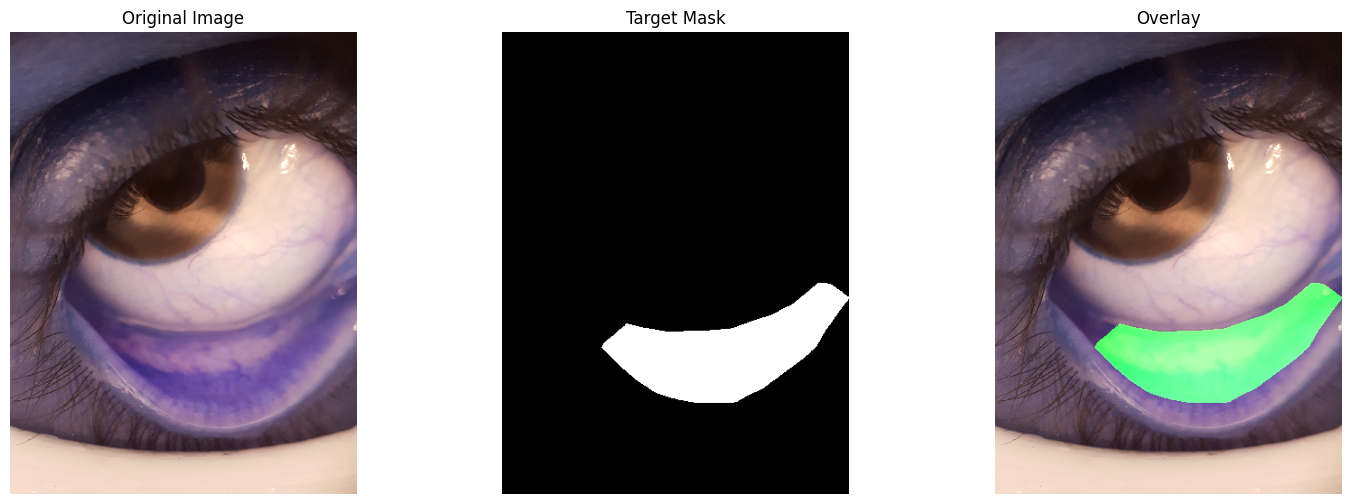

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to resize and convert PNG mask to binary
def preprocess_mask(target_mask_path, target_shape):

    # Load the mask image
    mask = cv2.imread(target_mask_path, cv2.IMREAD_UNCHANGED)

    # Resize the mask to the target shape
    mask = cv2.resize(mask, (target_shape[1], target_shape[0]))

    # Extract the alpha channel (assuming it contains the mask)
    alpha_channel = mask[:, :, 3]

    # Create a 3-channel mask
    rgb_mask = cv2.merge([alpha_channel, alpha_channel, alpha_channel])

    # Assuming target_mask is your mask array
    _, binary_mask = cv2.threshold(rgb_mask, 1, 255, cv2.THRESH_BINARY)

    binary_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)

    # Normalize to 0 and 1
    binary_mask = binary_mask / 255.0

    return binary_mask

# Function to load and preprocess original and target images
def load_data(original_path, target_path, target_shape):
    # print(original_path)
    # Read the original image
    original_image = cv2.imread(original_path)

    # Resize the original image to the target shape
    original_image = cv2.resize(original_image, (target_shape[1], target_shape[0]))

    # Normalize pixel values to the range [0, 1]
    original_image = original_image / 255.0

    # Read and preprocess the target mask
    target_mask = preprocess_mask(target_path, target_shape)

    return original_image, target_mask

# Function to overlay the mask on the original image
def overlay_mask(original_image, target_mask):
    # Create a copy of the original image
    overlay_image = original_image.copy()

    # Convert the mask to a 3-channel image
    mask_rgb = np.stack([target_mask] * 3, axis=-1)

    # Set the overlay color (here, using green)
    overlay_color = np.array([0, 1, 0])  # [B, G, R]

    # Apply the mask overlay
    overlay_image = overlay_image + (overlay_color * mask_rgb)

    # Clip values to be in the valid range [0, 1]
    overlay_image = np.clip(overlay_image, 0, 1)

    return overlay_image

# Function to visualize the original image, target mask, and overlay
def visualize(original_image, target_mask, overlay_image):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display the target mask
    axes[1].imshow(target_mask, cmap='gray')
    axes[1].set_title('Target Mask')
    axes[1].axis('off')

    # Display the overlay
    axes[2].imshow(overlay_image)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.show()

# Example usage
original_image_path = "./data/original/1.jpg"
target_mask_path = "./data/ROI/1.png"

# Set the target shape (3984, 2988) based on your original image dimensions
target_shape = (512, 384)

# Load and preprocess the data
original_image, target_mask = load_data(original_image_path, target_mask_path, target_shape)

# Overlay the mask on the original image
overlay_image = overlay_mask(original_image, target_mask)

# Visualize the original image, target mask, and overlay
visualize(original_image, target_mask, overlay_image)


In [13]:
original_path = './data/original/'
roi_path = './data/ROI/'
masks = []
originals = []
for i in range(len(os.listdir(original_path))):
  originals.append(load_data(os.path.join(original_path, f'{i+1}.jpg'), os.path.join(roi_path, f'{i+1}.png'), target_shape)[0])
  masks.append(load_data(os.path.join(original_path, f'{i+1}.jpg'), os.path.join(roi_path, f'{i+1}.png'), target_shape)[1])

libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
libpng warning: iCCP: CRC error
[ WARN:0@61.511] global loadsave.cpp:248

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [14]:
masks = np.array(masks)
originals = np.array(originals)
masks.shape, originals.shape

((40, 512, 384), (40, 512, 384, 3))

In [15]:
id = 68

original_image = originals[id]
target_mask = masks[id]

# Overlay the mask on the original image
overlay_image = overlay_mask(original_image, target_mask)

# Visualize the original image, target mask, and overlay
visualize(original_image, target_mask, overlay_image)

IndexError: index 68 is out of bounds for axis 0 with size 40

In [16]:
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Get the total number of images
total_images = originals.shape[0]

# Randomly shuffle indices
shuffled_indices = np.random.permutation(total_images)

# Define the number of images for training and testing
num_train = int(total_images * 0.75)  # 75% for training
num_test = total_images - num_train

# Split the indices
train_indices = shuffled_indices[:num_train]
test_indices = shuffled_indices[num_train:]

# Use the indices to get the training and testing sets
train_originals = originals[train_indices]
test_originals = originals[test_indices]
train_masks = masks[train_indices]
test_masks = masks[test_indices]

# Print the shapes to verify the split
print("Train Originals Shape:", train_originals.shape)
print("Test Originals Shape:", test_originals.shape)
print("Train Masks Shape:", train_masks.shape)
print("Test Masks Shape:", test_masks.shape)


Train Originals Shape: (30, 512, 384, 3)
Test Originals Shape: (10, 512, 384, 3)
Train Masks Shape: (30, 512, 384)
Test Masks Shape: (10, 512, 384)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define U-Net model
def unet_model(input_shape=(512, 384, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.concatenate([layers.UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.concatenate([layers.UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.concatenate([layers.UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create U-Net model
model = unet_model()

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Adjust the learning rate

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Print model summary
model.summary()

# Train the model
model.fit(train_originals, train_masks, epochs=50, batch_size=8, validation_split=0.2)

# Predict on test data
predictions = model.predict(test_originals)


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# predictions = []
# batch_size = 8

# for i in range(0, len(test_originals), batch_size):
#     batch_predictions = model.predict(test_originals[i:i+batch_size])
#     predictions.append(batch_predictions)

# predictions = np.concatenate(predictions, axis=0)


1/1 [==============================] - 0s 34ms/step


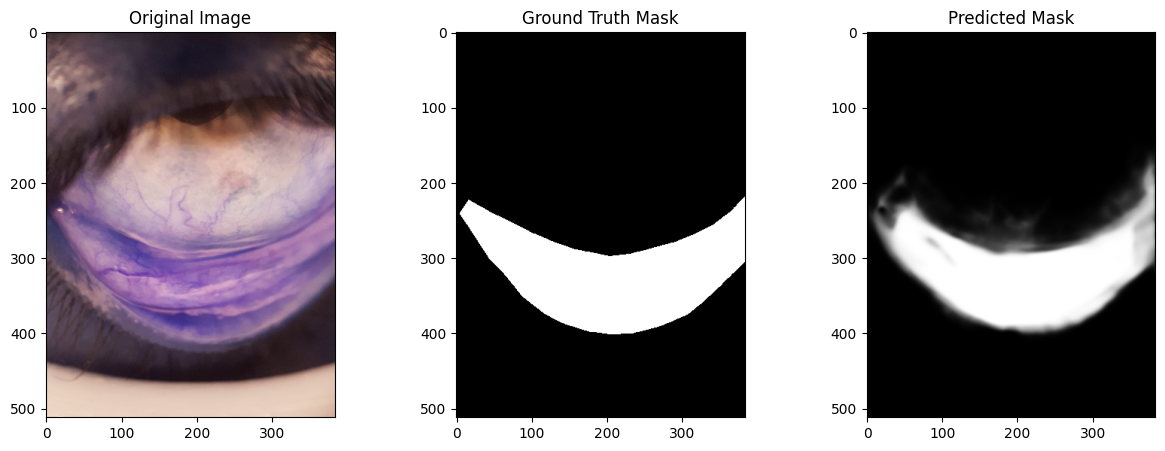

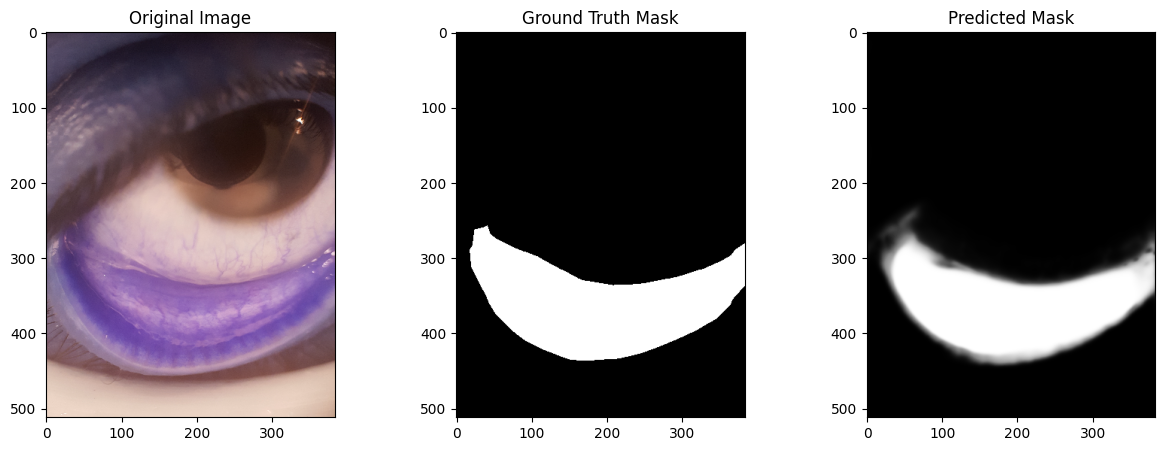

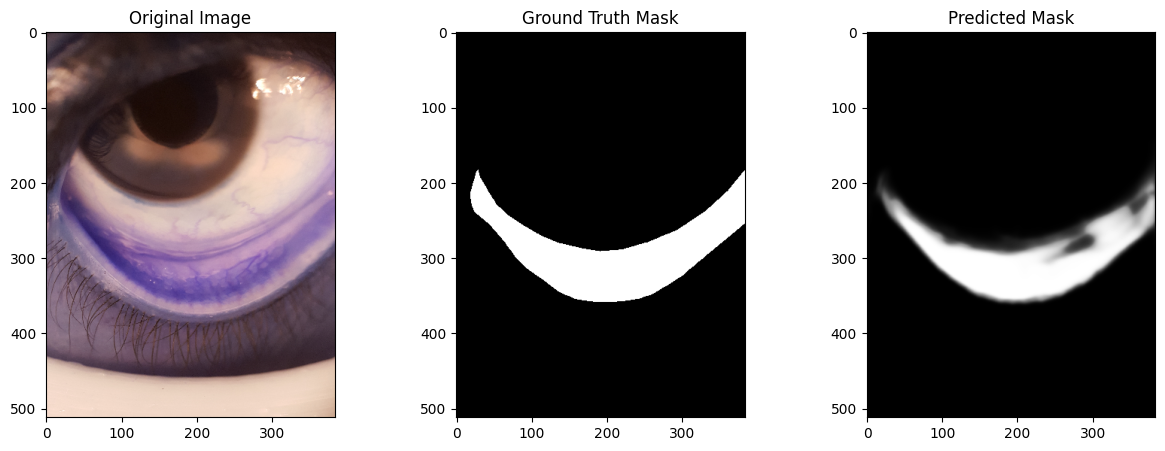

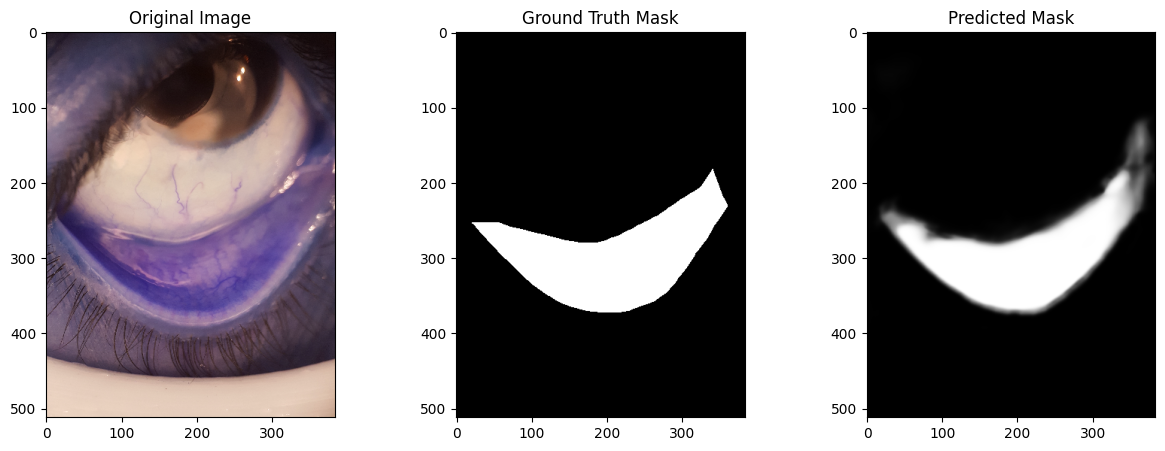

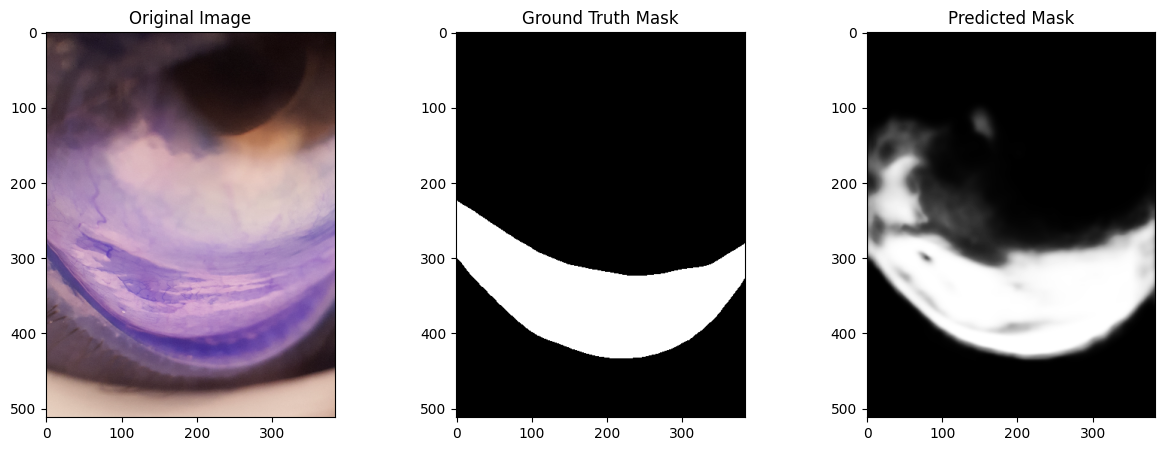

In [ ]:
# Binarize the predictions
predictions = (predictions > 0.5).astype(np.uint8)

# Visualize results for a few test images
num_samples_to_visualize = min(5, len(test_originals))

for i in range(num_samples_to_visualize):
    # Original Image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_originals[i])
    plt.title('Original Image')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[i], cmap='gray')
    plt.title('Ground Truth Mask')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i], cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

In [ ]:
np.unique(predictions)

array([1.4099538e-12, 1.4140879e-12, 1.4147947e-12, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

In [ ]:
#  !pip install tf-models-official

In [ ]:
# import tensorflow as tf
# import numpy as np
# import tensorflow_models as tfm

# # Convert numpy arrays to TensorFlow tensors
# masks_tensor = tf.convert_to_tensor(train_masks, dtype=tf.float32)
# originals_tensor = tf.convert_to_tensor(train_originals, dtype=tf.float32)

# # Add an extra dimension to masks
# masks_tensor = tf.expand_dims(masks_tensor, axis=-1)

# # Function to apply random augmentation techniques
# def augment_data(images, masks, num_augmented_images):
#     augmented_images = []
#     augmented_masks = []

#     for _ in range(num_augmented_images):
#         # Randomly select an image and its corresponding mask
#         index = tf.random.uniform(shape=(), maxval=tf.shape(images)[0], dtype=tf.int32)
#         selected_image = tf.gather(images, index)
#         selected_mask = tf.gather(masks, index)

#         # Add an extra dimension to selected mask
#         # selected_mask = tf.expand_dims(selected_mask, axis=-1)

#         # Randomly select an augmentation technique
#         augmentation_type = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)

#         # Augmentation: Angular Rotation
#         if augmentation_type == 0:
#             angle = tf.random.uniform(shape=(), minval=-9, maxval=10, dtype=tf.float32) * 5
#             selected_image, selected_mask = tf.image.rot90(selected_image, k=tf.cast(angle // 90, tf.int32)), tf.image.rot90(selected_mask, k=tf.cast(angle // 90, tf.int32))

#             if selected_image.shape[0] == 384:
#               selected_image, selected_mask = tf.transpose(selected_image, perm=[1,0,2]), tf.transpose(selected_mask, perm=[1,0,2])
#             # print(selected_image.shape, selected_mask.shape)

#         # Augmentation: Horizontal Flipping
#         elif augmentation_type == 1:
#             selected_image = tf.image.flip_left_right(selected_image)
#             selected_mask = tf.image.flip_left_right(selected_mask)

#         # Augmentation: Gaussian Blur
#         elif augmentation_type == 2:
#             sigma = tf.random.uniform(shape=(), minval=0.1, maxval=2.0, dtype=tf.float32)
#             selected_image = tfm.vision.augment.gaussian_filter2d(selected_image, filter_shape=(3, 3), sigma=sigma)


#         # Augmentation: Noise Addition
#         elif augmentation_type == 3:
#             noise = tf.random.normal(shape=tf.shape(selected_image), mean=0.0, stddev=0.1, dtype=tf.float32)
#             selected_image = selected_image + noise

#         # if selected_image.shape[0] == 384:
#         #   print(augmentation_type)
#         augmented_images.append([selected_image])
#         augmented_masks.append([selected_mask])  # Remove the extra dimension

#     # Convert augmented lists to tensors
#     augmented_images = tf.concat(augmented_images, axis=0)
#     augmented_masks = tf.concat(augmented_masks, axis=0)
#     augmented_masks = tf.squeeze(augmented_masks, axis = -1)
#     # print(augmented_masks.shape)

#     return augmented_images, augmented_masks

# # Set the desired number of augmented images
# desired_dataset_size = 400

# # Perform augmentation until the desired dataset size is reached
# while originals_tensor.shape[0] < desired_dataset_size:
#     additional_augmented_images, additional_augmented_masks = augment_data(originals_tensor, masks_tensor, desired_dataset_size - originals_tensor.shape[0])
#     originals_tensor = tf.concat([originals_tensor, additional_augmented_images], axis=0)
#     masks_tensor = tf.concat([tf.squeeze(masks_tensor, axis=-1), additional_augmented_masks], axis=0)

# # Convert augmented tensors to numpy arrays if needed
# augmented_images_np = originals_tensor.numpy()
# augmented_masks_np = masks_tensor.numpy()

# # Check the shape of augmented arrays
# print("Shape of Augmented Images:", augmented_images_np.shape)
# print("Shape of Augmented Masks:", augmented_masks_np.shape)


In [ ]:
# id = 200

# original_image = augmented_images_np[id]
# target_mask = augmented_masks_np[id]
# # print(original_image.shape)

# # Overlay the mask on the original image
# overlay_image = overlay_mask(original_image, target_mask)

# # Visualize the original image, target mask, and overlay
# visualize(original_image, target_mask, overlay_image)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, Reshape, Conv2DTranspose
# from tensorflow.keras.metrics import F1Score

# def lm_1(inputs):
#   x = BatchNormalization()(inputs)
#   # x = tf.pad(x, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='SYMMETRIC')
#   x = Conv2D(64, 7, strides=2, padding='same', use_bias=False)(x)
#   x = BatchNormalization()(x)
#   x = Activation('relu')(x)
#   # x = tf.pad(x, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='SYMMETRIC')
#   x = MaxPool2D(2, strides=2, padding='same')(x)
#   x1 = x
#   return x, x1

# def lm_2a(input):
#   x = BatchNormalization()(input)
#   x = Activation('relu')(x)
#   x1 = x
#   x = Conv2D(32, 3, strides=1, padding='same', use_bias=False)(x)
#   x = BatchNormalization()(x)
#   x = Activation('relu')(x)
#   x = Conv2D(64, 3, strides=1, padding='same', use_bias=False)(x)
#   x1 = Conv2D(64, 1, strides=1, padding='valid', use_bias=False)(x1)
#   return x + x1

# def lm_2b(input, n_filters):
#   x = BatchNormalization()(input)
#   x = Activation('relu')(x)
#   x1 = x
#   x = Conv2D(n_filters // 2, 3, strides=2, padding='same', use_bias=False)(x)
#   x = BatchNormalization()(x)
#   x = Activation('relu')(x)
#   x = Conv2D(n_filters, 3, strides=1, padding='same', use_bias=False)(x)
#   x1 = Conv2D(n_filters, 1, strides=2, padding='valid', use_bias=False)(x1)
#   return x + x1, x+x1

# def lm_3(input, num_filters):
#   x1 = input
#   x = BatchNormalization()(input)
#   x = Activation('relu')(x)
#   x = Conv2D(num_filters, 3, strides=1, padding='same', use_bias=False)(x)
#   x = BatchNormalization()(input)
#   x = Activation('relu')(x)
#   x = Conv2D(num_filters, 3, strides=1, padding='same', use_bias=False)(x)
#   # print(x.shape, x1.shape)
#   x = x + x1
#   return x

# def lm_4(input, skip):
#     height = input.shape[1] * 2
#     width = input.shape[2] * 2
#     filters = input.shape[3]

#     x = Conv2DTranspose(filters // 4, 3, 2, 'same')(input)
#     skip = Reshape((height, width, filters // 4))(skip)
#     x = Concatenate()([x, skip])

#     return x

# def lm_5(input, num_filters):

#   x = Conv2D(num_filters, 3, 1, 'same', use_bias=False)(input)
#   x = BatchNormalization()(x)
#   x = Activation('relu')(x)

#   return x

# def lm_6(input):

#   x = UpSampling2D()(input)
#   x = Conv2D(16, 1)(x)
#   x = BatchNormalization()(x)
#   x = Activation('relu')(x)
#   x = Conv2D(8, 1)(x)
#   x = BatchNormalization()(x)
#   x = Activation('relu')(x)

#   return x

# def top_encoder(inputs):

#   # Layer module 1
#   x, x1 = lm_1(inputs)
#   # print(x.shape, x1.shape)

#   # Layer module 2a
#   x = lm_2a(x)

#   # Layer module 3
#   x = lm_3(x, 64)
#   x = lm_3(x, 64)

#   return x, x1

# def encoder(input, n_lm_3, n_filters):

#   x, x1 = lm_2b(input, n_filters)
#   for i in range(n_lm_3):
#     x = lm_3(x, n_filters)

#   return x, x1

# def bottom(input):

#   x = BatchNormalization()(input)
#   x = Activation('relu')(x)

#   return x

# def decoder(input, skip, num_filters):

#   x = lm_4(input, skip)
#   x = lm_5(x, num_filters)
#   x = lm_5(x, num_filters)

#   return x

# def top_decoder(inputs, skips):

#   x = decoder(inputs, skips, 32)
#   x = lm_6(x)
#   x = Conv2D(1, 3, 1, 'same')(x)
#   x= Activation('sigmoid')(x)

#   return x

# def u_net(inputs):
#   # inputs is a 4D tensor of shape (batch_size, height, width, channels)

#   x, x1 = top_encoder(inputs)

#   # Layer module 2b
#   x, x2 = encoder(x, 3, 128)

#   x, x3 = encoder(x, 5, 256)

#   x, x4 = encoder(x, 2, 512)

#   x = bottom(x)

#   x = decoder(x, x4, 256)

#   x = decoder(x, x3, 128)

#   x = decoder(x, x2, 64)
#   # print(x.shape)

#   x = top_decoder(x, x1)

#   return x

In [ ]:
# # from tensorflow.keras.layers import

# inputs = Input(shape=(512, 384, 3))
# # skips = Input(shape=(64, 48, 128))

# output = u_net(inputs)

# model = tf.keras.Model(inputs=inputs, outputs=output)
# # Compile the model
# f1_score = F1Score(threshold = 0.5)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.MeanIoU(num_classes=2)])

# # Train the model
# model.fit(augmented_images_np, np.expand_dims(augmented_masks_np, -1), epochs=10, batch_size=8)